# Homework 4
---

Released on Nov 26 -- due by *Dec 3, 11:59pm*.

In this homework assignment we will develop a copy number caller based on a Hidden Markov Model. In addition, we will implement a hierarchical clustering algorithm. The data that we consider is from a previously published [breast tumor](http://dx.doi.org/10.1038/nature09807), from which 100 single cells have been sequenced. In this homework assignment we restrict our attention to a subset of 25 cells.

_Instructions:_ There are four questions, worth a total of 100 points. In addition, there are two bonus questions (Q2e and Q4c), each worth 5 points. Insert your answer after each question in the designated box. Replace comments with code.

Hand in your work by emailing the Jupyter notebook (please rename as "LASTNAME_FIRSTNAME.ipynb") to Anusri and myself.

---

## Question 1: Data preparation [20 points]

We start by parsing the data from `data.tsv` using pandas.

In [1]:
%matplotlib inline
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from __future__ import print_function

In [2]:
df = pd.read_csv("data.tsv", sep="\t", index_col=0)
df.head()

,CHR,START,END,SRR089377,SRR054598,SRR053605,SRR054594,SRR089397,SRR054614,SRR089402,...,SRR054606,SRR054613,SRR053631,SRR054575,SRR053679,SRR054604,SRR053611,SRR053607,SRR053602,SRR054610
bin,,,,,,,,,,,,,,,,,,,,,
0,chr1,1,1246396,2116,298,573,157,3146,1495,4071,...,854,1583,1106,1847,795,562,1211,636,751,1520
1,chr1,1246395,1833664,1940,264,660,204,1643,1207,3809,...,651,848,1252,2024,830,584,836,475,673,1185
2,chr1,1833663,2345598,1767,261,870,237,1655,1621,5418,...,707,1372,1342,2531,1153,874,936,630,818,1366
3,chr1,2345597,2946628,2246,446,854,265,1564,1838,5625,...,1227,1172,1578,2909,1373,884,1184,604,973,1701
4,chr1,2946627,3452945,2189,363,883,217,2081,1173,4845,...,687,1371,1562,3235,1053,854,785,649,784,1212


This dataset consists of the following 25 cells:

In [3]:
cells = list(df.columns[3:])
sys.stdout.write("Cells:")
for idx, cell in enumerate(cells):
    if idx % 5 == 0:
        sys.stdout.write("\n")
    sys.stdout.write(cell + " ")

Cells:
SRR089377 SRR054598 SRR053605 SRR054594 SRR089397 
SRR054614 SRR089402 SRR053676 SRR053633 SRR053617 
SRR054608 SRR053608 SRR054602 SRR089401 SRR053668 
SRR054606 SRR054613 SRR053631 SRR054575 SRR053679 
SRR054604 SRR053611 SRR053607 SRR053602 SRR054610 

The reads of each cell are put in bins. As seen in the command below, there are 5363 bins.

We plot a histogram of the bin sizes as follows, from which we can see that most of the bins have length 500,000.

(500000, 1000000)

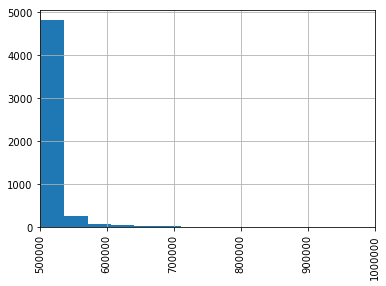

In [5]:
(df['END'] - df['START'] + 1).hist(bins=1000, xrot=90)
plt.xlim((500000, 1000000))

### _Q1a:_ What is the minimum, median and maximum bin size? [4 points]

In [6]:
# TODO: insert code to print the min, median and max bin size
bin_sizes = (df['END'] - df['START'] + 1)
print("min: " + str(bin_sizes.min()))
print("median: " + str(bin_sizes.median()))
print("max: " + str(bin_sizes.max()))

min: 501688
median: 514870.0
max: 35387248


_Answer:_ 
* min: 501688
* median: 514870.0
* max: 35387248

We retain bins with lengths between 450,000 and 500,000 using the following command.

In [7]:
df = df[(450000 <= (df['END'] - df['START'] + 1)) & ((df['END'] - df['START'] + 1) <= 550000)]

In [8]:
df.shape

(4949, 28)

### _Q1b:_ The column `CHR` contains the chromosome label. Do these cells originate from a male or female patient? [4 points]

In [9]:
# TODO: write code here to print unique list of values in 'CHR' column
if 'chrY' in df['CHR'].unique():
    print("male")
else:
    print("female")

male


_Answer:_ male

Next, we remove the sex chromosomes such that each bin in a normal cell has copy number 2.
### _Q1c:_ How many bins occur on autosomal chromosomes? [4 points]

In [10]:
# TODO: insert code to generate a list of chromosome labels corresponding to autosomes, e.g. ['chr1', 'chr2', ...]
autosomes = list(df['CHR'].unique())
autosomes.remove("chrX")
autosomes.remove("chrY")

In [11]:
print(str(len(df[df['CHR'].isin(autosomes)])) + " bins")

4718 bins


_Answer:_ 4718 bins

In [12]:
# we retain only autosomes
df = df[df['CHR'].isin(autosomes)]

Due to variablity in library preparation, there are differences in the total number of reads per cell. We construct a new dataframe with the total number of reads, and plot a histogram as follows.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10e7e9588>]], dtype=object)

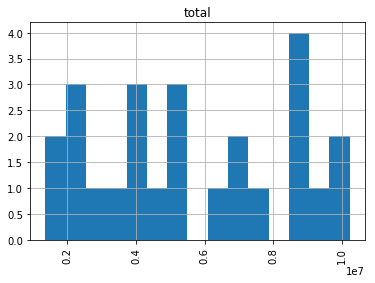

In [13]:
df_total_reads = pd.DataFrame.from_records([(cell, int(df[cell].sum())) for cell in cells], columns=['cell', 'total'])
df_total_reads.hist(column="total", bins=15, xrot=90)

### _Q1d:_ Based on the above plot, we decide to exclude the six cells with a total read count of less than 3,000,000 reads. Which six cells are excluded? [4 points]

In [14]:
cells_to_keep = list(df_total_reads[df_total_reads['total'] >= 3000000]['cell'])

In [15]:
# TODO: insert code to filter down to cells with less 3,000,000 reads
df_removed_cells = list(df_total_reads[df_total_reads['total'] < 3000000]['cell'])

In [16]:
for ix, cell in enumerate(df_removed_cells):
    print(str(ix+1) + ". " + cell + " with " + str(df_total_reads[df_total_reads['cell'] == cell]['total'].iloc[0]) + " reads;")

1. SRR054598 with 1784898 reads;
2. SRR054594 with 1361308 reads;
3. SRR053676 with 2036366 reads;
4. SRR053679 with 2021242 reads;
5. SRR054604 with 2473778 reads;
6. SRR053607 with 2784633 reads;


_Answer:_ 
1. SRR054598 with 1784898 reads;
2. SRR054594 with 1361308 reads;
3. SRR053676 with 2036366 reads;
4. SRR053679 with 2021242 reads;
5. SRR054604 with 2473778 reads;
6. SRR053607 with 2784633 reads.

In [17]:
# we retain only cells with >= 3,000,000 reads
df = df[list(df.columns)[:3] + cells_to_keep]

The key concept is that the majority of bins in a cell are diploid. Since the bins have the same length and under the assumption of uniform genome coverage, we expect the most frequent read count, or the mode, to correspond to the diploid state. We identify the mode by discretizing the read counts for each cell into 20 bins. We then divide the read count for each bin in a cell by the mode.

### _Q1e:_ Complete the below code fragment to identify the mode of each cell and to subsequently normalize the read counts. [4 points]

In [18]:
nr_bins = 20
df2 = df.copy(deep=True)
for cell in cells_to_keep:
    # insert code to discretize read count (e.g. first integer division by bin_size, then multiply by bin_size)
    largest = df[cell].max()
    bin_size = largest / nr_bins
    df2[cell] = (df2[cell] / bin_size).astype(int) * bin_size
#     df2[cell] = pd.to_numeric(df2[cell] / bin_size, downcast='signed')*bin_size
#     print(df2[cell].mode())
df_mode = pd.DataFrame.from_records([(cell, int(df2[cell].mode())) for cell in cells_to_keep], 
                                    columns=['cell', 'mode'])

In [19]:
# TODO: insert code to divide each read count by the mode of the corresponding cell
for cell in cells_to_keep:
    df[cell] = df[cell] / df_mode[df_mode['cell'] == cell]['mode'].iloc[0]

In [20]:
# The following commented out code generates data_filtered.tsv, which is part of the zip file of this assignment. 
# If your code is correct the resulting file should be identical to the provided file.
df.to_csv("my_data_filtered_normalized.tsv", sep="\t")

## Question 2: Viterbi algorithm [50 points]

In this question we use the Viterbi algorithm to compute a copy number for each bin. The set $Q$ of hidden states corresponds to integer copy numbers. We consider $Q=\{0,\ldots,10\}$. The set $\Sigma$ of emitted symbols are normalized read counts. Since this an infinite set, we use a probability distribution function for each integer copy number to define the emission probabilities. Specifically, for copy number $c \in \{0,\ldots,10\}$ we use a normal distribution with standard deviation $\sigma = 0.1$ centered around mean $\mu_c = c / 2$.

In [21]:
df_norm = pd.read_table("data_filtered_normalized.tsv", sep="\t", index_col=0)

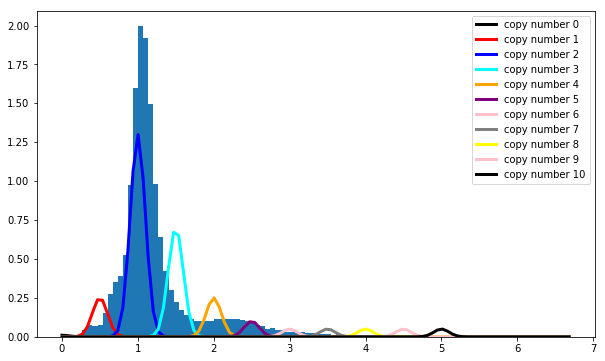

In [22]:
def gauss(x, mu, sigma, A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

values = [val for sublist in [list(df_norm[cell]) for cell in list(df_norm.columns[3:])] for val in sublist]
count, bins, ignored = plt.hist(values, bins=100, normed=True)

sigma = 0.1

plt.plot(np.array([0,.05,.1,.15,.2]),gauss(np.array([0,.05,.1,.15,.2]), 0, sigma, .01),color='black',lw=3,label='copy number 0')
plt.plot(bins,gauss(bins, 0.5, sigma, .25),color='red',lw=3,label='copy number 1')
plt.plot(bins,gauss(bins, 1, sigma, 1.3),color='blue',lw=3,label='copy number 2')
plt.plot(bins,gauss(bins, 1.5, sigma, .7),color='cyan',lw=3,label='copy number 3')
plt.plot(bins,gauss(bins, 2, sigma, .25),color='orange',lw=3,label='copy number 4')
plt.plot(bins,gauss(bins, 2.5, sigma, .1),color='purple',lw=3,label='copy number 5')
plt.plot(bins,gauss(bins, 3, sigma, .05),color='pink',lw=3,label='copy number 6')
plt.plot(bins,gauss(bins, 3.5, sigma, .05),color='gray',lw=3,label='copy number 7')
plt.plot(bins,gauss(bins, 4, sigma, .05),color='yellow',lw=3,label='copy number 8')
plt.plot(bins,gauss(bins, 4.5, sigma, .05),color='pink',lw=3,label='copy number 9')
plt.plot(bins,gauss(bins, 5, sigma, .05),color='black',lw=3,label='copy number 10')

plt.legend()
plt.gcf().set_size_inches(10, 6)

In [23]:
from scipy.stats import norm
max_copy_number = 10

def emissionLogProb(copy_number, norm_count):
    sigma = 0.1
    mu = copy_number / 2.

    # Compute Pr(|X_c - norm_count| <= 0.01 | c)  
    low = norm.cdf(norm_count - 0.01, mu, sigma)
    up = norm.cdf(norm_count + 0.01, mu, sigma)
    
    # prevent probability of 0
    prob = max(up - low, 0.0001)
    
    return np.log(prob)

def transitionLogProb(current_copy_number, next_copy_number):
    stay_prob = 0.99999
    if current_copy_number == next_copy_number:
        return np.log(stay_prob)
    elif 0 <= next_copy_number <= max_copy_number:
        return np.log((1 - stay_prob) / max_copy_number)
    else:
        return np.log(0)

def initialLogProb(copy_number):
    if 0 <= copy_number <= max_copy_number:
        return np.log(1./11)
    else:
        return np.log(0)

### _Q2a:_ Compute the joint log probability of each cell having copy number 2 in all bins. [10 points]

_Hint:_ Make use of the functions `emissionLogProb`, `initialLogProb` and `transitionLogProb`.

In [24]:
for cell in list(df_norm.columns[3:]):
    log_prob = 0
    for idx, norm_count in df_norm[cell].iteritems():
        # TODO: insert code here
        # Hint: idx == 0 is the initial item.
        if idx == 0:
            log_prob = initialLogProb(2) + emissionLogProb(2, norm_count)
        else:
            log_prob += (transitionLogProb(2, 2) + emissionLogProb(2, norm_count))
        pass
    
    print(cell, log_prob)

SRR089377 -15219.7890468
SRR053605 -15578.1006822
SRR089397 -15341.8931791
SRR054614 -28486.4420592
SRR089402 -37689.6404253
SRR053633 -17980.6652756
SRR053617 -16591.8332474
SRR054608 -28629.6462536
SRR053608 -17018.8848998
SRR054602 -29999.5632173
SRR089401 -35737.2750215
SRR053668 -23687.5611228
SRR054606 -36758.6830117
SRR054613 -28302.2927571
SRR053631 -21786.4992071
SRR054575 -34594.3911538
SRR053611 -15430.5565018
SRR053602 -18423.8537
SRR054610 -28584.2876249


### _Q2b:_ Determine the maximum joint log probability of each cell using the Viterbi algorithm. [20 points]

_Hint:_ Complete the function `viterbi` and `max_joint_prob`, making use of the functions `emissionLogProb`, `initialLogProb` and `transitionLogProb`.

In [25]:
def viterbi(df_norm, cell):
    # Positions
    bins = sorted(list(df_norm.index))

    # Set of states (copy numbers)
    Q = range(max_copy_number+1)
    
    # Initialization v[copy_number][bin] = 0
    v = [ { bin : 0 for bin in bins } for c in range(max_copy_number + 1) ]
    
    for idx, bin in enumerate(bins):
        norm_count = float(df.loc[bin][cell])
        # TODO: insert code here
        for curr_copy_number in Q:
            if idx == 0:
                v[curr_copy_number][bin] = initialLogProb(curr_copy_number) + emissionLogProb(curr_copy_number, norm_count)
            else:
                max_val = v[Q[0]][bins[idx-1]] + transitionLogProb(Q[0], curr_copy_number)
                for prev_copy_number in Q[1:]:
                    curr_val = v[prev_copy_number][bins[idx-1]] + transitionLogProb(prev_copy_number, curr_copy_number)
                    if max_val < curr_val:
                        max_val = curr_val
                v[curr_copy_number][bin] = emissionLogProb(curr_copy_number, norm_count) + max_val
    return v

def max_joint_prob(df_norm, v):
    # Positions
    bins = sorted(list(df_norm.index))
    
    # Set of states (copy numbers)
    Q = range(max_copy_number+1)
    last_bin = bins[-1]
    
    # TODO: insert code here
    max_val = v[Q[0]][last_bin]
    for copy_number in Q[1:]:
        if max_val < v[copy_number][last_bin]:
            max_val = v[copy_number][last_bin]
    return max_val

V = {}
for cell in list(df_norm.columns[3:]):
    V[cell] = viterbi(df_norm, cell)
    print(cell, "--", "max prob:", max_joint_prob(df_norm, V[cell]))

SRR089377 -- max prob: -15135.0709671
SRR053605 -- max prob: -15545.0612915
SRR089397 -- max prob: -15308.7651581
SRR054614 -- max prob: -21459.8597147
SRR089402 -- max prob: -26926.6988675
SRR053633 -- max prob: -17806.4769912
SRR053617 -- max prob: -16345.749228
SRR054608 -- max prob: -21893.7359408
SRR053608 -- max prob: -16321.148714
SRR054602 -- max prob: -22052.950647
SRR089401 -- max prob: -25818.2409156
SRR053668 -- max prob: -17933.5003724
SRR054606 -- max prob: -25598.4462157
SRR054613 -- max prob: -21730.2333361
SRR053631 -- max prob: -21461.5081743
SRR054575 -- max prob: -26713.5279913
SRR053611 -- max prob: -15312.762621
SRR053602 -- max prob: -18024.0675712
SRR054610 -- max prob: -21836.1956978


### _Q2c:_ Compute the most likely copy number profile for each cell. [10 points]

_Hint:_ Hint perform a backtrace or extend the above `viterbi` function to maintain backpointers.

In [26]:
def viterbi_bt(df_norm, cell):
    # Positions
    bins = sorted(list(df_norm.index))

    # Set of states (copy numbers)
    Q = range(max_copy_number+1)
    
    # Initialization v[copy_number][bin] = 0
    v = [ { bin : 0 for bin in bins } for c in range(max_copy_number + 1) ]
    bt = [ { bin : None for bin in bins } for c in range(max_copy_number + 1) ]
    
    for idx, bin in enumerate(bins):
        # TODO: insert code here
        norm_count = float(df.loc[bin][cell])
        for curr_copy_number in Q:
            if idx == 0:
                v[curr_copy_number][bin] = initialLogProb(curr_copy_number) + emissionLogProb(curr_copy_number, norm_count)
                bt[curr_copy_number][bin] = -1
            else:
                max_val = v[Q[0]][bins[idx-1]] + transitionLogProb(Q[0], curr_copy_number)
                bt[curr_copy_number][bin] = 0
                for prev_copy_number in Q[1:]:
                    curr_val = v[prev_copy_number][bins[idx-1]] + transitionLogProb(prev_copy_number, curr_copy_number)
                    if max_val < curr_val:
                        max_val = curr_val
                        bt[curr_copy_number][bin] = prev_copy_number
                v[curr_copy_number][bin] = emissionLogProb(curr_copy_number, norm_count) + max_val
    return v, bt

bins = sorted(list(df_norm.index))
Q = range(max_copy_number+1)

V = {}
BT = {}
C = {}
for cell in list(df_norm.columns[3:]):
    V[cell], BT[cell] = viterbi_bt(df_norm, cell)
    C[cell] = {}
    
    max_prob = max_joint_prob(df_norm, V[cell])
    final_c = None
    final_bin = bins[-1]
    for c in Q:
        if V[cell][c][final_bin] == max_prob:
            final_c = c
    
    C[cell][final_bin] = final_c
    
    for idx in range(len(bins)-2, -1, -1):
        bin = bins[idx]
        next_bin = bins[idx + 1]
        next_bin_c = C[cell][next_bin]
        C[cell][bin] = BT[cell][next_bin_c][next_bin]
    
    print(cell, "--", "max prob:", max_joint_prob(df_norm, V[cell]))

SRR089377 -- max prob: -15135.0709671
SRR053605 -- max prob: -15545.0612915
SRR089397 -- max prob: -15308.7651581
SRR054614 -- max prob: -21459.8597147
SRR089402 -- max prob: -26926.6988675
SRR053633 -- max prob: -17806.4769912
SRR053617 -- max prob: -16345.749228
SRR054608 -- max prob: -21893.7359408
SRR053608 -- max prob: -16321.148714
SRR054602 -- max prob: -22052.950647
SRR089401 -- max prob: -25818.2409156
SRR053668 -- max prob: -17933.5003724
SRR054606 -- max prob: -25598.4462157
SRR054613 -- max prob: -21730.2333361
SRR053631 -- max prob: -21461.5081743
SRR054575 -- max prob: -26713.5279913
SRR053611 -- max prob: -15312.762621
SRR053602 -- max prob: -18024.0675712
SRR054610 -- max prob: -21836.1956978


### _Q2d:_ Which cells are normal cells (i.e. have copy number 2 for each bin)? [10 points]

_Hint:_ Use `visualizeCopyNumbers(C, bins)`.

_Answer:_  
SRR089377  
SRR053605  
SRR089397  
SRR053633  
SRR053617  
SRR053608  
SRR053611

In [27]:
bins = sorted(list(df_norm.index))

In [28]:
def visualizeCopyNumbers(C, bins):
    nrRows = 5
    nrCols = 4
    for idx, cell in enumerate(C):
        ax = plt.subplot(nrRows, nrCols, idx+1)
        plt.step(range(len(bins)), list(C[cell].values()))
        ax.set_title(cell)
        ax.set_ylim((0, 10))
        ax.set_xlabel("bin")
        ax.set_ylabel("copy number")
    plt.gcf().set_size_inches(30, 20)
    plt.tight_layout()
    plt.savefig("viterbi.pdf")

In [29]:
print("The following cells have a copy number of 2:")
for cell in C.keys():
    copy_numbers = list(C[cell].values())
    if copy_numbers.count(copy_numbers[0]) == len(copy_numbers):
        print(cell)

The following cells have a copy number of 2:
SRR089377
SRR053605
SRR089397
SRR053633
SRR053617
SRR053608
SRR053611


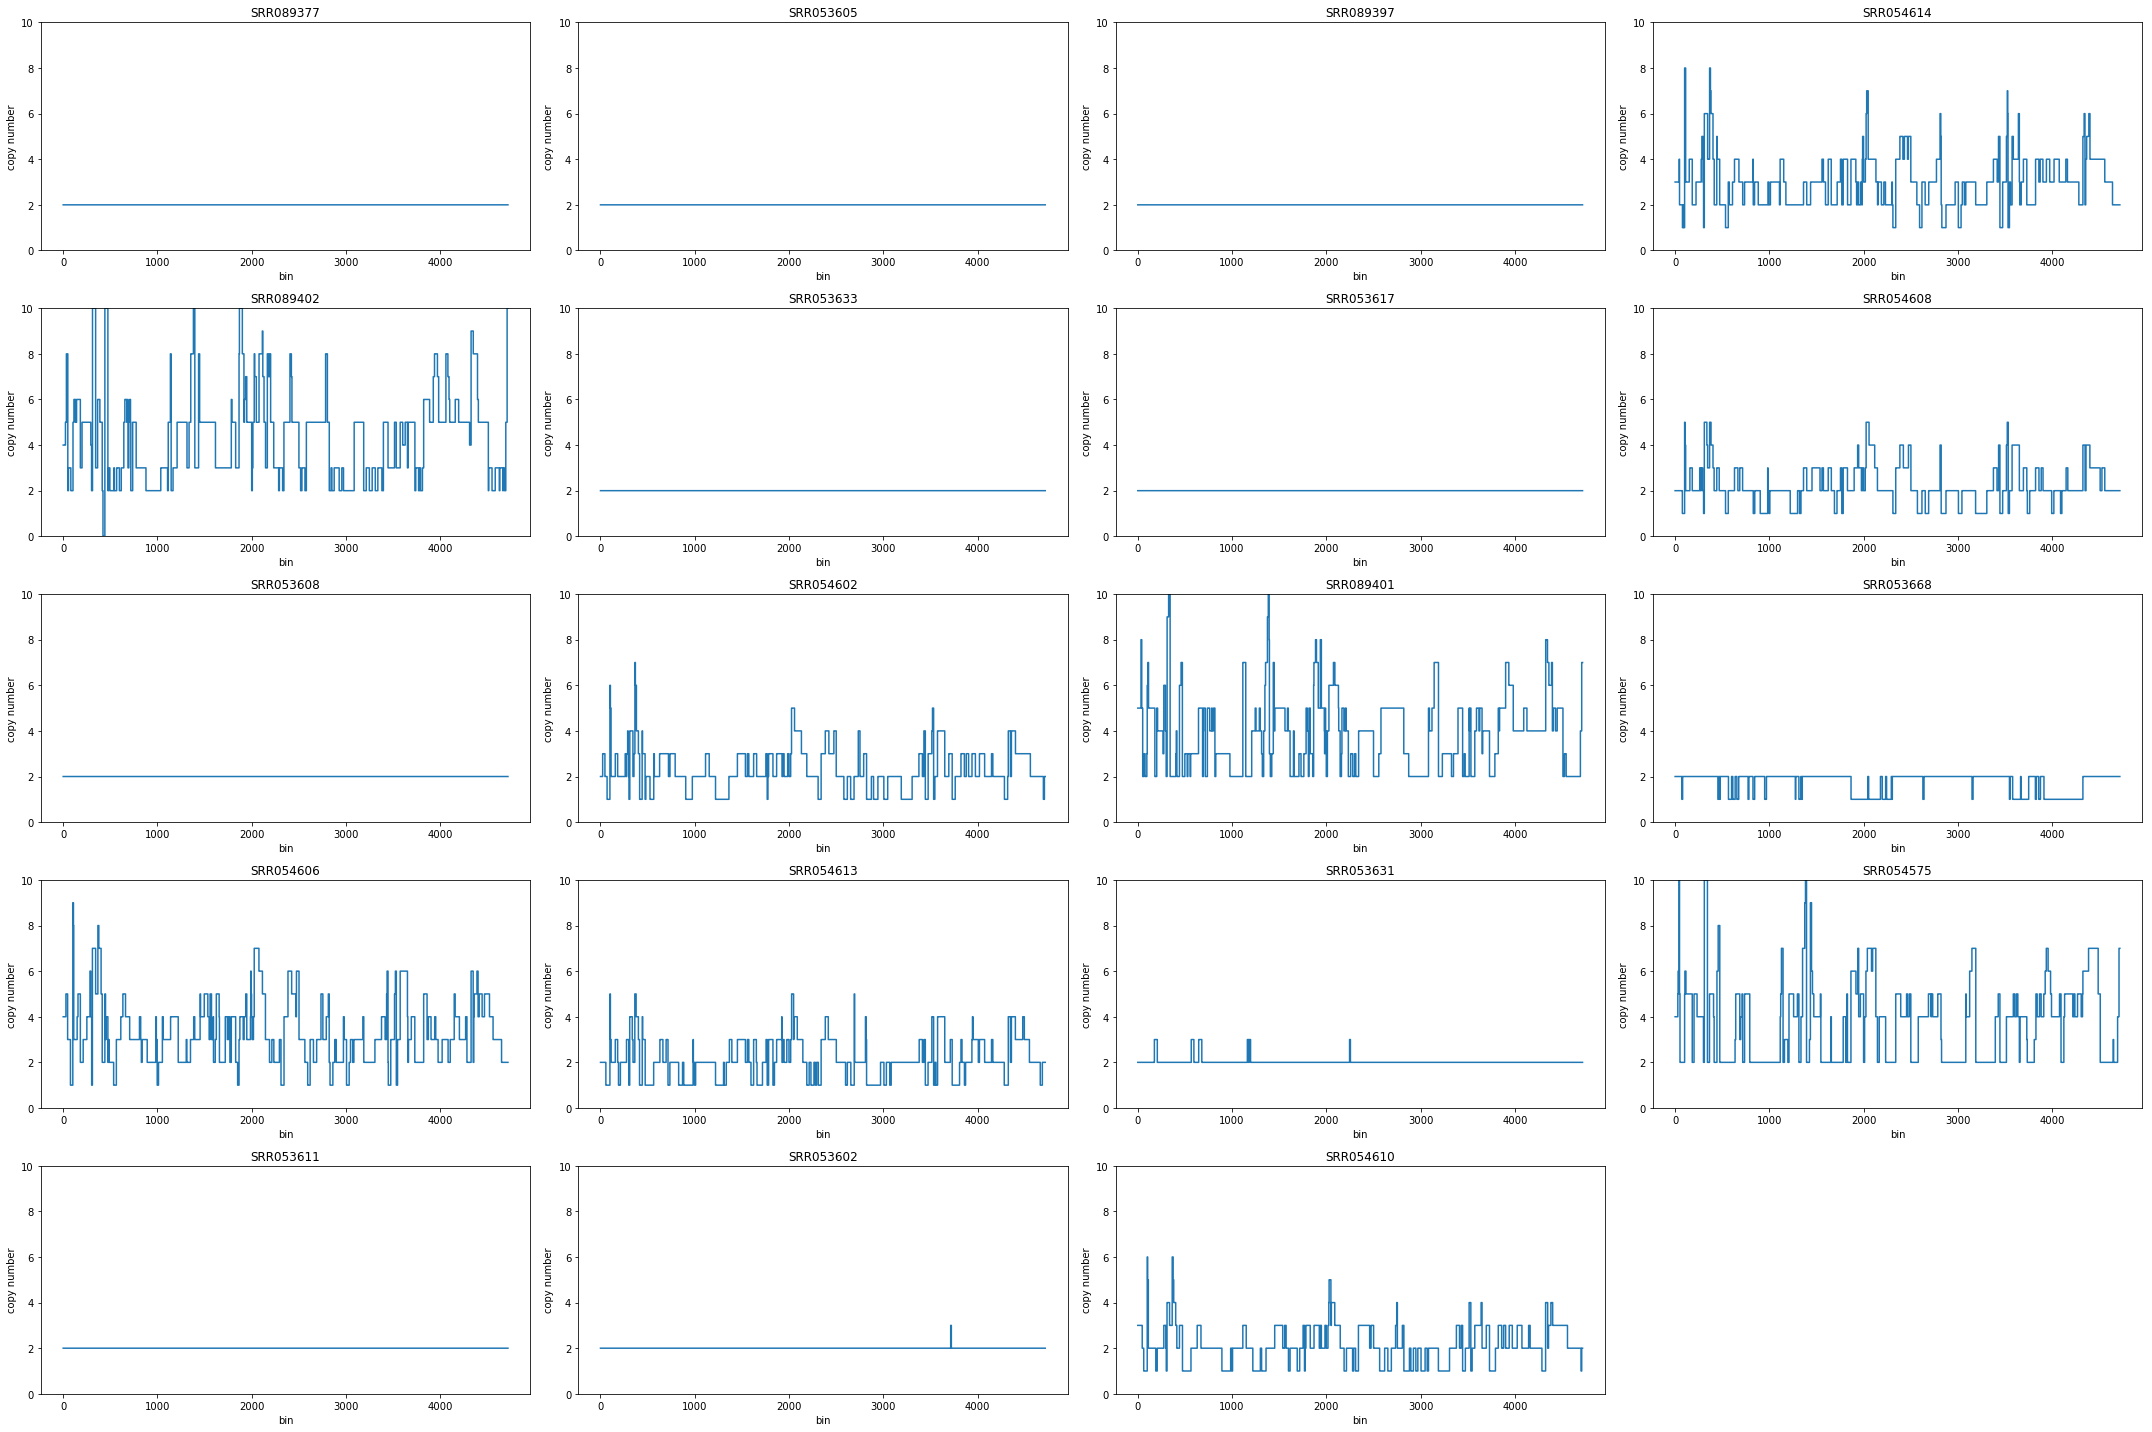

In [30]:
visualizeCopyNumbers(C, bins)

### _Q2e -- Bonus:_ Extend the plotting function to delineate chromosomes using vertical lines. Do not forget to update x-axis labels to show chromosomes. [5 points]

In [31]:
temp_df = df_norm.copy(deep=True)
temp_df = temp_df.sort_index()
grouped = temp_df.groupby('CHR').groups
chrom_location = {}
for name, group in grouped.items():
    chrom_location[name] = temp_df.index.get_loc(group.max())

In [32]:
def visualizeCopyNumbers(C, bins):
    nrRows = 5
    nrCols = 4
    sorted_locs = sorted(list(chrom_location.values()))
    for idx, cell in enumerate(C):
        ax = plt.subplot(nrRows, nrCols, idx+1)
        plt.step(range(len(bins)), list(C[cell].values()))
        plt.xticks(sorted_locs, range(1, 23, 1))
        ax.set_title(cell)
        ax.set_ylim((0, 10))
        ax.set_xlabel("chromosomes")
        ax.set_ylabel("copy number")
        for chrom, location in chrom_location.items():
            ax.axvline(x=location, label=chrom)
    plt.gcf().set_size_inches(30, 20)
    plt.tight_layout()
    plt.savefig("viterbi.pdf")

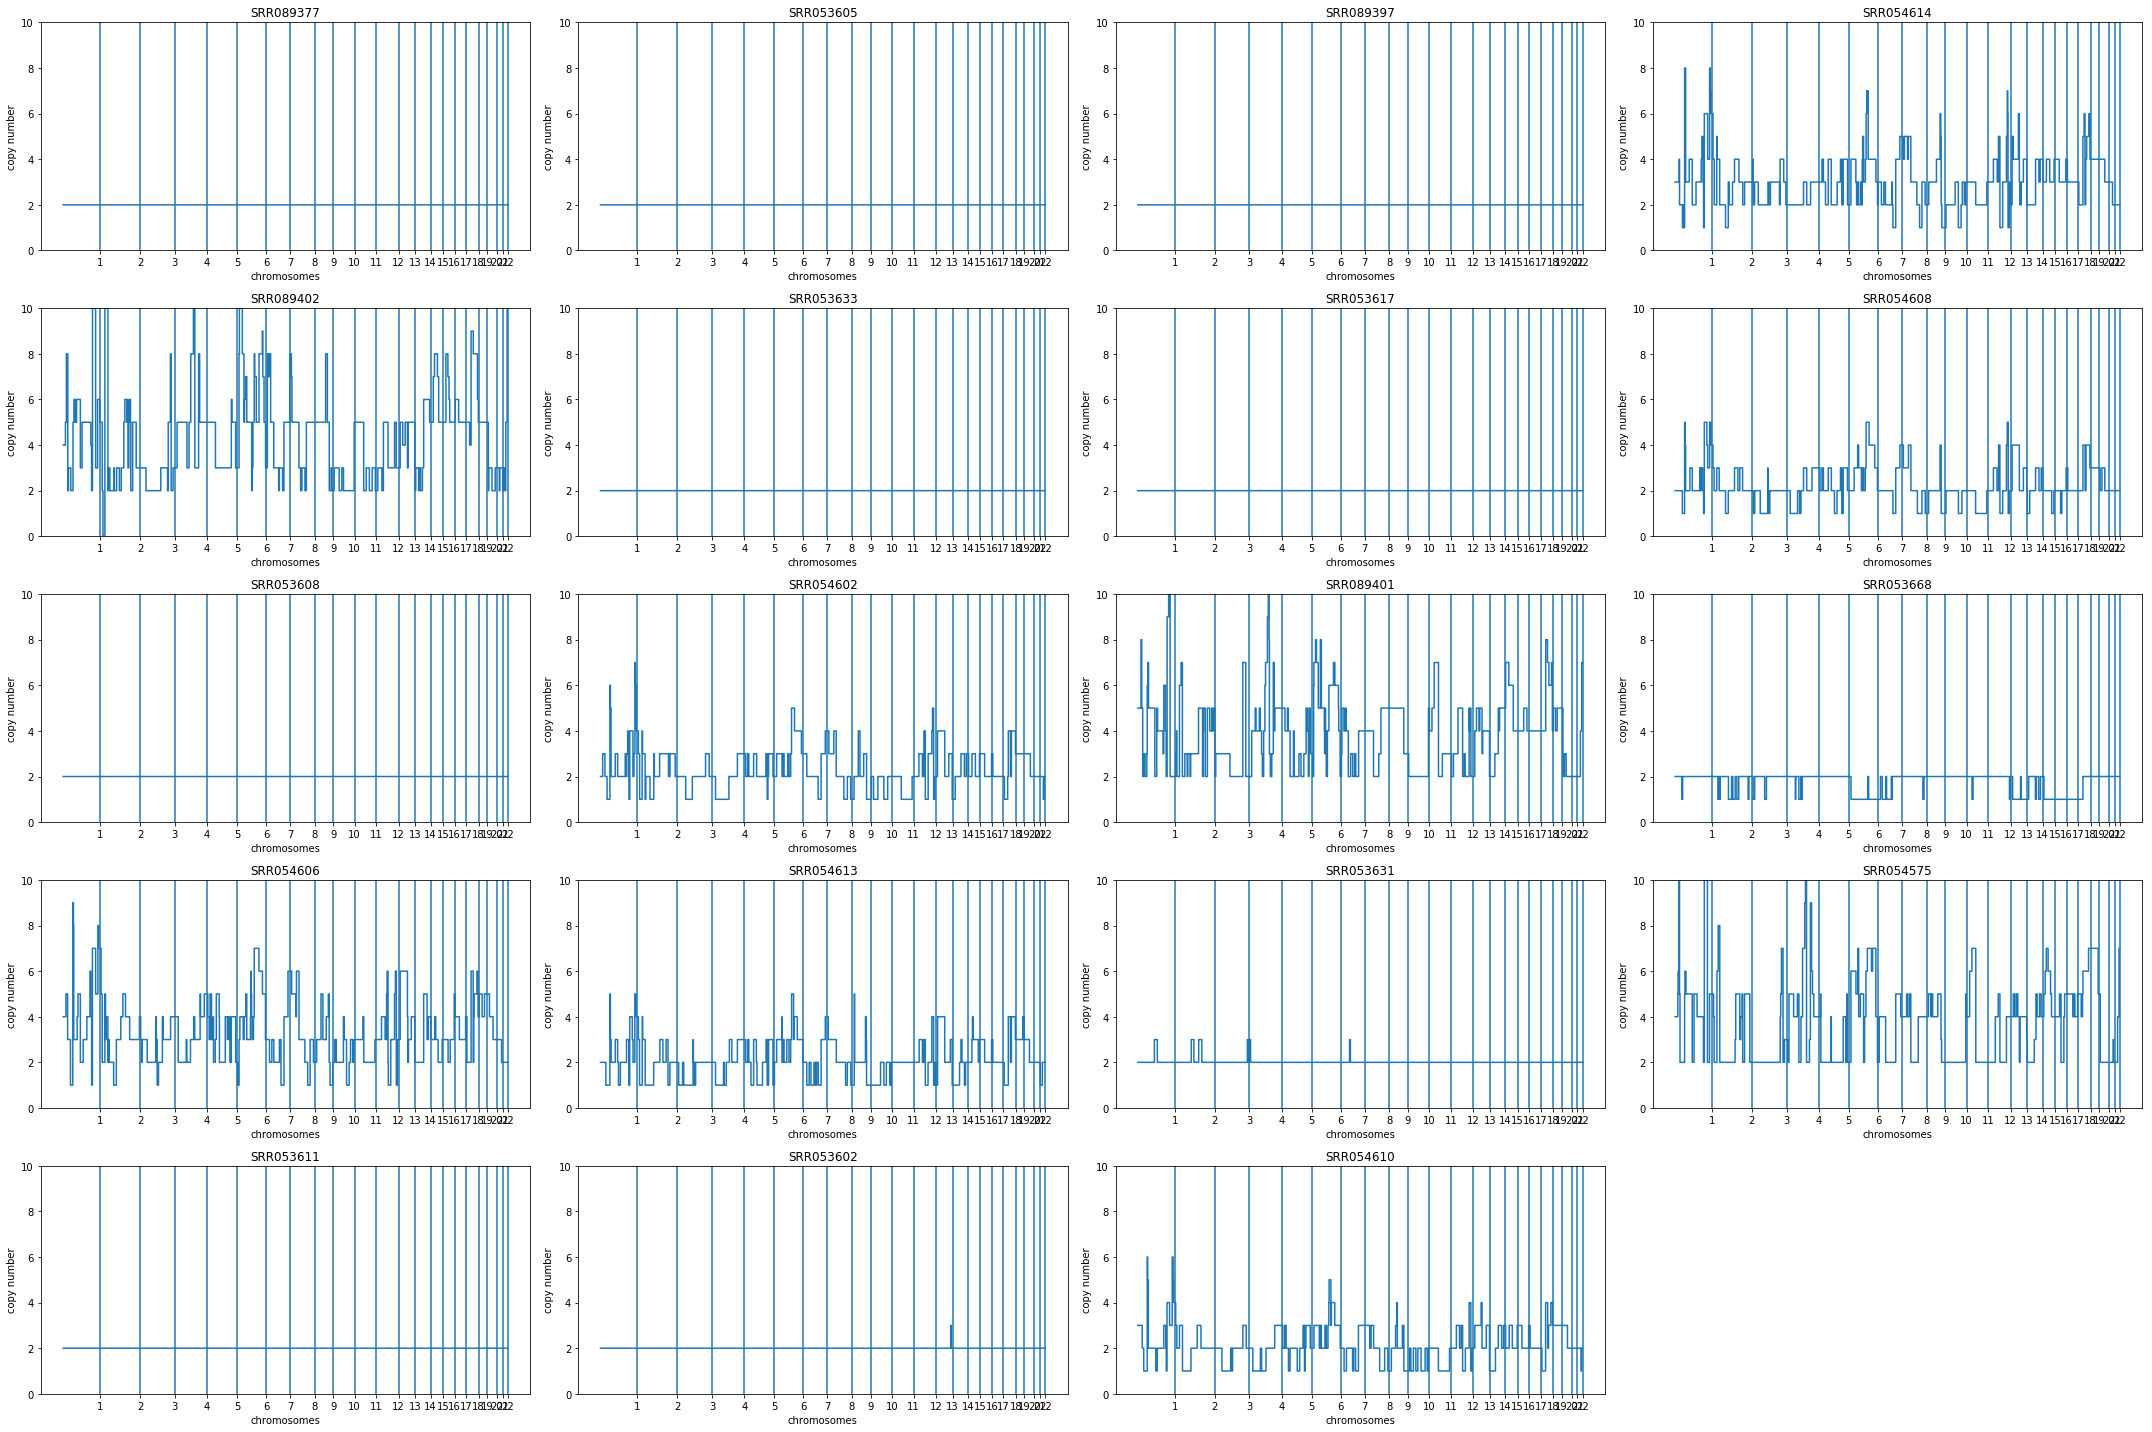

In [33]:
visualizeCopyNumbers(C, bins)

## Question 3: Forward algorithm [10 points]

### _Q3a:_ Compute the marginal log probability of the observations using the forward algorithm. [10 points]
_Hint:_ Be aware that recurrence of the forward algorithm includes a summation, but we are operating in log space.

In [143]:
def forward(df_norm, cell):
    # Positions
    bins = sorted(list(df_norm.index))

    # Set of states (copy numbers)
    Q = range(max_copy_number+1)
    
    # Initialization f[copy_number][bin] = 0
    f = [ { bin : 0 for bin in bins } for c in Q ]
#     scale = 10**(-4)

    for idx, bin in enumerate(bins):
        norm_count = float(df.loc[bin][cell])
        # TODO: insert code here
        for curr_copy_num in Q:
            if (idx == 0):
                f[curr_copy_num][bin] = np.exp(initialLogProb(curr_copy_num)) * np.exp(emissionLogProb(curr_copy_num, norm_count))
            else:
                f[curr_copy_num][bin] = 0
                for prev_copy_num in Q:
                    f[curr_copy_num][bin] += (f[prev_copy_num][bins[idx-1]] * np.exp(transitionLogProb(prev_copy_num, curr_copy_num)))
                f[curr_copy_num][bin] *= np.exp(emissionLogProb(curr_copy_num, norm_count))
    return f

def marginal_log_prob(df_norm, f):
    # Positions
    bins = sorted(list(df_norm.index))
    
    # Set of states (copy numbers)
    Q = range(max_copy_number+1)
    last_bin = bins[-1]
    
    # insert code here
    marginal_log_prob = 0
    for copy_num in Q:
        marginal_log_prob += f[copy_num][last_bin]
    return marginal_log_prob

F = {}
for cell in list(df_norm.columns[3:]):
    F[cell] = forward(df_norm, cell)
    print(cell, "--", "marginal log prob:", marginal_log_prob(df_norm, F[cell]))

SRR089377 -- marginal log prob: 0.0
SRR053605 -- marginal log prob: 0.0
SRR089397 -- marginal log prob: 0.0
SRR054614 -- marginal log prob: 0.0
SRR089402 -- marginal log prob: 0.0
SRR053633 -- marginal log prob: 0.0
SRR053617 -- marginal log prob: 0.0
SRR054608 -- marginal log prob: 0.0
SRR053608 -- marginal log prob: 0.0
SRR054602 -- marginal log prob: 0.0
SRR089401 -- marginal log prob: 0.0
SRR053668 -- marginal log prob: 0.0
SRR054606 -- marginal log prob: 0.0
SRR054613 -- marginal log prob: 0.0
SRR053631 -- marginal log prob: 0.0
SRR054575 -- marginal log prob: 0.0
SRR053611 -- marginal log prob: 0.0
SRR053602 -- marginal log prob: 0.0
SRR054610 -- marginal log prob: 0.0


In [146]:
# ref: http://users-cs.au.dk/cstorm/courses/ML_e15/slides/hmm-ml-2-implementations.pdf
def forward(df_norm, cell):
    # Positions
    bins = sorted(list(df_norm.index))

    # Set of states (copy numbers)
    Q = range(max_copy_number+1)
    
    # Initialization f[copy_number][bin] = 0
    f = [ { bin : 0 for bin in bins } for c in Q ]
    f_hat = [ { bin : 0 for bin in bins } for c in Q ]
    c = {bin : 0 for bin in bins}
    delta = {copy_num : 0 for copy_num in Q}
    c_prod = 1

    for idx, bin in enumerate(bins):
        norm_count = float(df.loc[bin][cell])
        # TODO: insert code here
        for curr_copy_num in Q:
            if (idx == 0):
                delta[curr_copy_num] = np.exp(initialLogProb(curr_copy_num)) * np.exp(emissionLogProb(curr_copy_num, norm_count))
                c[bin] += delta[curr_copy_num]
            else:
                delta[curr_copy_num] = 0
                for prev_copy_num in Q:
                    delta[curr_copy_num] += (f_hat[prev_copy_num][bins[idx-1]] * np.exp(transitionLogProb(prev_copy_num, curr_copy_num)))
                delta[curr_copy_num] *= np.exp(emissionLogProb(curr_copy_num, norm_count))
                c[bin] += delta[curr_copy_num]
        c_prod *= c[bin]
        for curr_copy_num in Q:
            f_hat[curr_copy_num][bin] = delta[curr_copy_num] / c[bin]
            f[curr_copy_num][bin] = f_hat[curr_copy_num][bin] * c_prod
    return f

def marginal_log_prob(df_norm, f):
    # Positions
    bins = sorted(list(df_norm.index))
    
    # Set of states (copy numbers)
    Q = range(max_copy_number+1)
    last_bin = bins[-1]
    
    # insert code here
    marginal_log_prob = 0
    for copy_num in Q:
        marginal_log_prob += f[copy_num][last_bin]
    return marginal_log_prob

F = {}
for cell in list(df_norm.columns[3:]):
    F[cell] = forward(df_norm, cell)
    print(cell, "--", "marginal log prob:", marginal_log_prob(df_norm, F[cell]))
    break

SRR089377 -- marginal log prob: 0.0


## Question 4: Hierarchical clustering [20 points]
The Python package `scipy` implements hierarchical clustering. We will use this method to perform single linkage cluster with the Manhattan (also known as cityblock) distance metric.

In [34]:
C_values = [[value for value in C[cell].values()] for cell in C]
C_labels = [cell for cell in C]

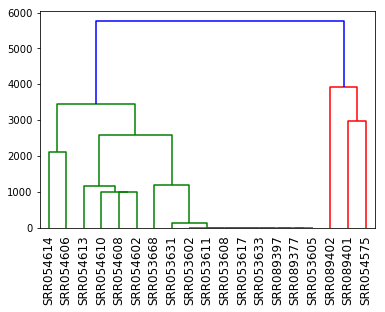

In [35]:
from scipy.cluster import hierarchy
Z = hierarchy.linkage(C_values, 'single', 'cityblock')
plt.figure()
dn = hierarchy.dendrogram(Z, labels=C_labels, leaf_rotation=90)

The goal of this question is to reimplement this algorithm. We start by computing the initial distance matrix.

### _Q4a:_ Compute the initial distance matrix using Manhattan distance. [10 points]

In [36]:
def manhattan(C, cell_1, cell_2, bins):
    # TODO: insert code here
    manhat_dist = 0
    for bin in bins:
        manhat_dist += (abs(C[cell_1][bin] - C[cell_2][bin]))
    return manhat_dist

bins = sorted(list(df_norm.index))
dist = {}
for cell_1 in C.keys():
    dist[cell_1] = {}
    for cell_2 in C.keys():
        dist[cell_1][cell_2] = manhattan(C, cell_1, cell_2, bins)

### _Q4b:_ Implement single linkage clustering. [10 points]
_Hint:_ The documentation for the required output format is described here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage

In [39]:
import copy

def cluster(distances):
    distances = copy.deepcopy(distances)
    clusters = set(distances.keys())
    n = len(clusters)
    cluster2idx = { cell : idx for idx, cell in enumerate(clusters) }
    idx2cluster = [cell for idx, cell in enumerate(clusters)]
    Z = np.empty((0, 4), float)
    membership = [ set([cluster2idx[cell]]) for cell in clusters ]
    while len(clusters) > 1:
        # TODO: insert code to identify pair (c1, c2) with minimum distance dist
        temp_dist, c1, c2 = None, None, None

        for cluster1 in clusters:
            for cluster2 in clusters:
                if cluster2 == cluster1:
                    continue
                if (temp_dist == None) or (temp_dist > distances[cluster1][cluster2]):
                    temp_dist = distances[cluster1][cluster2]
                    c1 = cluster1
                    c2 = cluster2
        idx_c1 = cluster2idx[c1]
        idx_c2 = cluster2idx[c2]
        new_cluster = n + len(Z)
        new_cluster_idx = len(idx2cluster)

        membership.append( membership[idx_c1] | membership[idx_c2])
        Z = np.append(Z, 
                      np.array([[cluster2idx[c1], cluster2idx[c2], temp_dist, len(membership[new_cluster_idx])]]), 
                      axis=0)

        clusters.add(new_cluster)
        cluster2idx[new_cluster] = len(idx2cluster)
        idx2cluster.append(new_cluster)
        clusters.remove(c1)
        clusters.remove(c2)
        # TODO: insert code to update distances, find the distance of new cluster to every other cluster
        distances[new_cluster] = {}
        for clus in clusters:
            # find distance between each pair of points from new_cluster and clus
            if clus == new_cluster:
                continue
            clus_ix = cluster2idx[clus]
            min_dist = None
            for cell_1_ix in membership[new_cluster_idx]:
                for cell_2_ix in membership[clus_ix]:
                    cell_1 = idx2cluster[cell_1_ix]
                    cell_2 = idx2cluster[cell_2_ix]
                    if (min_dist == None) or (min_dist > distances[cell_1][cell_2]) :
                        min_dist = distances[cell_1][cell_2]
            distances[new_cluster][clus] = min_dist
            distances[clus][new_cluster] = min_dist
        
    return Z, idx2cluster[:n]

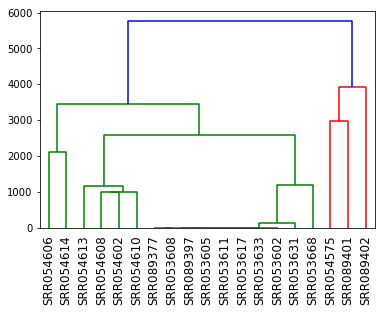

In [40]:
Z, labels = cluster(dist)
plt.figure()
dn = hierarchy.dendrogram(Z, labels=labels, leaf_rotation=90)

### _Q4c -- Bonus:_ Implement complete linkage clustering. [5 points]
_Hint:_ The documentation for the required output format is described here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage. Your plot should be identical to the below scipy plot.

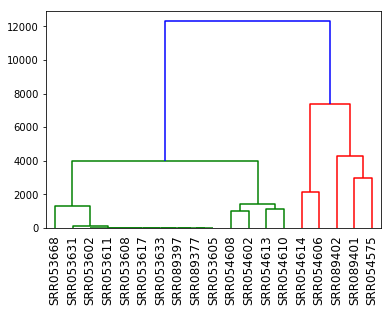

In [41]:
from scipy.cluster import hierarchy
Z = hierarchy.linkage(C_values, 'complete', 'cityblock')
plt.figure()
dn = hierarchy.dendrogram(Z, labels=C_labels, leaf_rotation=90)

In [42]:
import copy

def cluster_complete(distances):
    distances = copy.deepcopy(distances)
    clusters = set(distances.keys())
    n = len(clusters)
    cluster2idx = { cell : idx for idx, cell in enumerate(clusters) }
    idx2cluster = [cell for idx, cell in enumerate(clusters)]
    Z = np.empty((0, 4), float)
    membership = [ set([cluster2idx[cell]]) for cell in clusters ]
    while len(clusters) > 1:
        # TODO: insert code to identify pair (c1, c2) with minimum distance dist
        temp_dist, c1, c2 = None, None, None

        for cluster1 in clusters:
            for cluster2 in clusters:
                if cluster2 == cluster1:
                    continue
                if (temp_dist == None) or (temp_dist > distances[cluster1][cluster2]):
                    temp_dist = distances[cluster1][cluster2]
                    c1 = cluster1
                    c2 = cluster2
        idx_c1 = cluster2idx[c1]
        idx_c2 = cluster2idx[c2]
        new_cluster = n + len(Z)
        new_cluster_idx = len(idx2cluster)

        membership.append( membership[idx_c1] | membership[idx_c2])
        Z = np.append(Z, 
                      np.array([[cluster2idx[c1], cluster2idx[c2], temp_dist, len(membership[new_cluster_idx])]]), 
                      axis=0)

        clusters.add(new_cluster)
        cluster2idx[new_cluster] = len(idx2cluster)
        idx2cluster.append(new_cluster)
        clusters.remove(c1)
        clusters.remove(c2)
        # TODO: insert code to update distances, find the distance of new cluster to every other cluster
        distances[new_cluster] = {}
        for clus in clusters:
            # find distance between each pair of points from new_cluster and clus
            if clus == new_cluster:
                continue
            clus_ix = cluster2idx[clus]
            max_dist = None
            for cell_1_ix in membership[new_cluster_idx]:
                for cell_2_ix in membership[clus_ix]:
                    cell_1 = idx2cluster[cell_1_ix]
                    cell_2 = idx2cluster[cell_2_ix]
                    if (max_dist == None) or (max_dist < distances[cell_1][cell_2]) :
                        max_dist = distances[cell_1][cell_2]
            distances[new_cluster][clus] = max_dist
            distances[clus][new_cluster] = max_dist
        
    return Z, idx2cluster[:n]

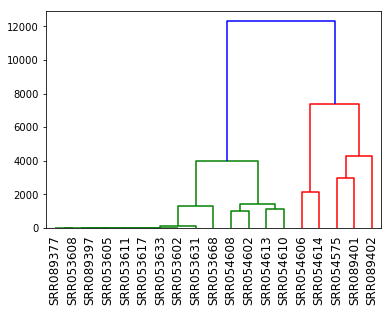

In [43]:
Z_complete, labels_complete = cluster_complete(dist)
plt.figure()
dn = hierarchy.dendrogram(Z_complete, labels=labels_complete, leaf_rotation=90)